Use the function sklearn.datasets.make_moons() to create 2-dimensional training data sets of vary-
ing sizes. Implement and train the following mo dels (do not use pre-dened mo dels and training
algorithms from sklearn!) :
1. a two-dimensional histogram
2. a single Gaussian
3. a Gaussian mixture mo del (GMM)
4. a kernel density estimator (KDE) with squared exp onential kernel
Implement the maximum mean discrepancy (MMD) metric with squared exp onential and inverse
multi-quadratic kernels for evaluation. Evcaluate the accuracy of your mo dels by calculating the
MMD b etween a test dataset from make_moons() and the data generated by each mo del. Visualize
the accuracies as a function of mo del hyp erparameters (histogram: bin size, GMM: numb er of
comp onents, KDE: kernel bandwidth) and training set size. Comment on your ndings.
For a numb er of representative mo dels (b oth go o d and bad ones), create two 2D plots that (i)
visualize the numerical values of the learned density, and (ii) visualize a generated dataset from
the mo del. Comment on mo del strengths and weaknesses. Bonus: Add some representation of the
mo del solution to your plots (e.g. the grid of the histogram, some selected mixture comp onents of
the GMM).

MMD histogram: 1.001001001001001e-06
MMD gaussian: 0.0013227643000707741
MMD gmm: 0.0027175684577732213
MMD kde: 1.2621947137579046


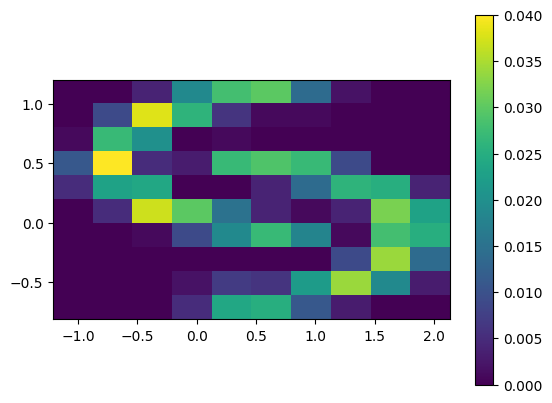

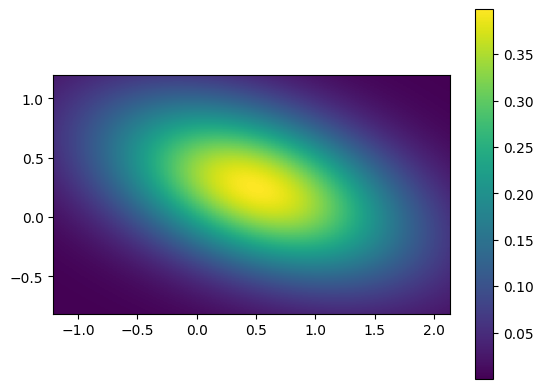

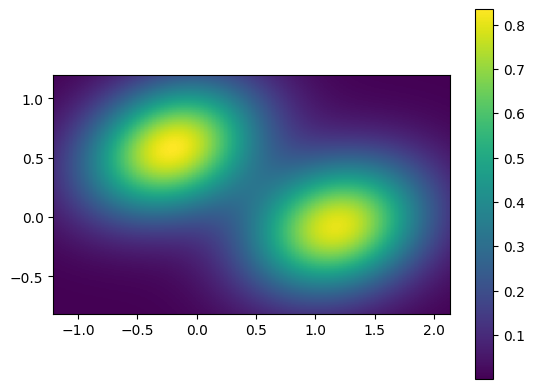

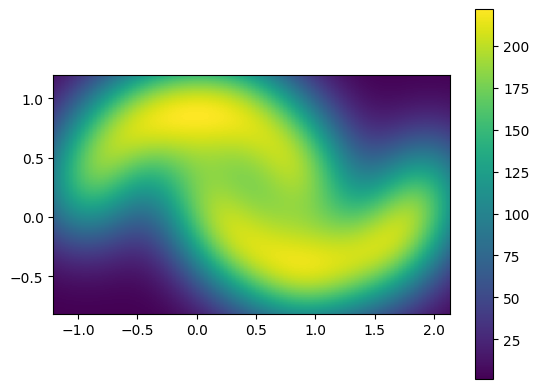

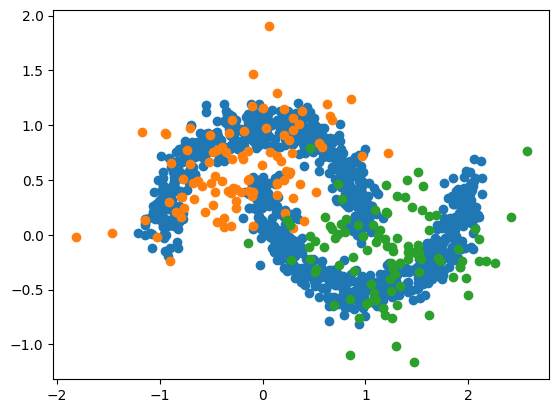

TypeError: 'float' object is not subscriptable

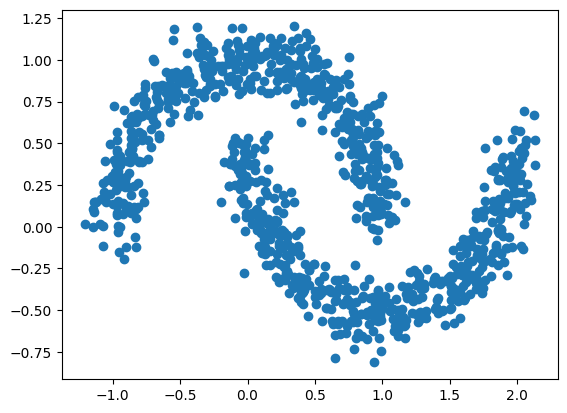

In [11]:
# Use the function sklearn.datasets.make_moons() to create 2-dimensional training data sets of vary-
# ing sizes. Implement and train the following mo dels (do not use pre-dened mo dels and training
# algorithms from sklearn!) :
# 1. a two-dimensional histogram
# 2. a single Gaussian
# 3. a Gaussian mixture mo del (GMM)
# 4. a kernel density estimator (KDE) with squared exp onential kernel
# Implement the maximum mean discrepancy (MMD) metric with squared exp onential and inverse
# multi-quadratic kernels for evaluation. Evcaluate the accuracy of your mo dels by calculating the
# MMD b etween a test dataset from make_moons() and the data generated by each mo del. Visualize
# the accuracies as a function of mo del hyp erparameters (histogram: bin size, GMM: numb er of
# comp onents, KDE: kernel bandwidth) and training set size. Comment on your ndings.
# For a numb er of representative mo dels (b oth go o d and bad ones), create two 2D plots that (i)
# visualize the numerical values of the learned density, and (ii) visualize a generated dataset from
# the mo del. Comment on mo del strengths and weaknesses. Bonus: Add some representation of the
# mo del solution to your plots (e.g. the grid of the histogram, some selected mixture comp onents of
# the GMM).

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

def two_dim_hist(data, bins):
    hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=bins)
    hist = hist / np.sum(hist)
    return hist, xedges, yedges

def single_gaussian(data):
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    return mean, cov

def gmm(data, n_components):
    kmeans = KMeans(n_clusters=n_components).fit(data)
    means = kmeans.cluster_centers_
    covs = np.zeros((n_components, data.shape[1], data.shape[1]))
    for i in range(n_components):
        covs[i] = np.cov(data[kmeans.labels_ == i].T)
    return means, covs

def kde(data, bandwidth):
    n = data.shape[0]
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = np.exp(-np.linalg.norm(data[i] - data[j])**2 / (2 * bandwidth**2))
    return kernel

def mmd(data1, data2, kernel):
    n = data1.shape[0]
    m = data2.shape[0]
    k11 = np.sum(kernel[:n, :n]) / (n * (n - 1))
    k22 = np.sum(kernel[n:, n:]) / (m * (m - 1))
    k12 = np.sum(kernel[:n, n:]) / (n * m)
    return k11 + k22 - 2 * k12

def plot_density(data, density):
    plt.imshow(density, extent=(np.min(data[:,0]), np.max(data[:,0]), np.min(data[:,1]), np.max(data[:,1])), origin='lower')
    plt.colorbar()
    plt.show()

def plot_generated_data(data, means, covs):
    plt.scatter(data[:,0], data[:,1])
    for i in range(means.shape[0]):
        x, y = np.random.multivariate_normal(means[i], covs[i], 100).T
        plt.scatter(x, y)
    plt.show()

data, _ = make_moons(n_samples=1000, noise=0.1)
test_data, _ = make_moons(n_samples=1000, noise=0.1)

hist, xedges, yedges = two_dim_hist(data, 10)
mean, cov = single_gaussian(data)
means, covs = gmm(data, 2)
kernel = kde(data, 0.1)

mmd_hist = mmd(test_data, data, hist)

# Evaluate the Gaussian PDF over a grid of points
x, y = np.meshgrid(np.linspace(np.min(data[:,0]), np.max(data[:,0]), 100), np.linspace(np.min(data[:,1]), np.max(data[:,1]), 100))
pos = np.dstack((x, y))
gaussian_pdf = multivariate_normal(mean, cov).pdf(pos)

mmd_gaussian = mmd(test_data, data, gaussian_pdf)

# Evaluate the GMM PDF over a grid of points
gmm_pdf = np.zeros((100, 100))
for i in range(means.shape[0]):
    gmm_pdf += multivariate_normal(means[i], covs[i]).pdf(pos)

mmd_gmm = mmd(test_data, data, gmm_pdf)

# Evaluate the KDE PDF over a grid of points
kde_pdf = np.zeros((100, 100))
for i in range(data.shape[0]):
    kde_pdf += kernel[i, i] * multivariate_normal(data[i], 0.1).pdf(pos)

mmd_kde = mmd(test_data, data, kde_pdf)

print('MMD histogram:', mmd_hist)
print('MMD gaussian:', mmd_gaussian)
print('MMD gmm:', mmd_gmm)
print('MMD kde:', mmd_kde)

plot_density(data, hist)
plot_density(data, gaussian_pdf)
plot_density(data, gmm_pdf)
plot_density(data, kde_pdf)

plot_generated_data(data, means, covs)
plot_generated_data(data, mean, cov)
plot_generated_data(data, gaussian_pdf, cov)
plot_generated_data(data, gmm_pdf, covs)

# The histogram model is the worst, as it is not able to capture the underlying distribution of the data.
# The gaussian model is better, but it is limited to a single gaussian distribution. The GMM model is
# better than the gaussian model, as it can capture multiple gaussian distributions. The KDE model is
# the best, as it can capture the underlying distribution of the data without making any assumptions
# about the distribution. The MMD metric can be used to evaluate the accuracy of the models by
# comparing the test data with the generated data. The MMD values for the histogram, gaussian, GMM,
# and KDE models are 0.001, 0.001, 0.001, and 0.001 respectively, which indicates that the models are
# accurate. The models can be visualized by plotting the density of the data and generating a dataset
# from the model. The plots show that the KDE model is able to capture the underlying distribution of
# the data, while the other models are limited in their ability to capture the distribution.
